# Association Rule Mining with Apriori Algorithm: Online Purchase Behavior During Crisis

This notebook explores association rule mining using the Apriori algorithm to discover interesting patterns in consumer perceptions of online purchasing during a crisis period. We'll extract meaningful rules to understand factors influencing online shopping behavior.

## Table of Contents
1. Introduction and Setup
2. Data Loading and Exploration
3. Data Preprocessing for Association Rules 
4. Applying the Apriori Algorithm
5. Rule Generation and Evaluation
6. Analysis of Top Rules
7. Visualization of Key Rules
8. Conclusion and Recommendations

## 1. Introduction and Setup




In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')



In this section, we import essential libraries for data analysis, visualization, and association rule mining:
- pandas and numpy for data manipulation
- matplotlib and seaborn for visualization
- mlxtend for implementing the Apriori algorithm
- networkx for network visualizations of rules

## 2. Data Loading and Exploration




In [4]:
# Load the cleaned survey data
df = pd.read_csv('../../data/cleaned/cleaned_survey_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nColumns related to online purchase intention:")
opi_columns = [col for col in df.columns if col.startswith('opi_')]
print(opi_columns)

# Basic summary statistics
print("\nBasic statistics for key measures:")
print(df[opi_columns].describe().round(2))

# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"\nTotal missing values in the dataset: {missing_values}")

Dataset shape: (825, 137)

Columns related to online purchase intention:
['opi_satisfaction', 'opi_behavior_change', 'opi_convenience', 'opi_value', 'opi_purchased?']

Basic statistics for key measures:
       opi_satisfaction  opi_behavior_change  opi_convenience  opi_value  \
count            825.00               825.00           825.00     825.00   
mean               3.74                 3.90             3.84       3.78   
std                0.82                 0.71             0.73       0.76   
min                1.00                 1.00             1.00       1.00   
25%                3.00                 4.00             3.00       3.00   
50%                4.00                 4.00             4.00       4.00   
75%                4.00                 4.00             4.00       4.00   
max                5.00                 5.00             5.00       5.00   

       opi_purchased?  
count          825.00  
mean             0.97  
std              0.18  
min             



Here we:
1. Load the cleaned survey data
2. Examine basic dataset characteristics (shape, columns)
3. Focus on Online Purchase Intention (OPI) variables
4. Check for any missing values that might affect our rule mining

## 3. Data Preprocessing for Association Rules




In [6]:
# Function to bin/discretize continuous variables into categories
# Updated function with better handling of limited-value distributions
def discretize_ratings(df, columns, prefix='', num_bins=3):
    """
    Convert numeric ratings into categorical bins for association rule mining
    
    Args:
        df: DataFrame containing the data
        columns: List of columns to discretize
        prefix: Optional prefix to add to the new categorical variables
        num_bins: Number of bins to create
    
    Returns:
        Dataframe with discretized columns added
    """
    result_df = df.copy()
    
    # Define the labels for our bins
    if num_bins == 3:
        labels = ['Low', 'Medium', 'High']
    elif num_bins == 5:
        labels = ['Very_Low', 'Low', 'Medium', 'High', 'Very_High']
    else:
        labels = [f'Bin_{i+1}' for i in range(num_bins)]
    
    for col in columns:
        # Skip columns that are not numeric
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue
            
        # Check number of unique values
        unique_values = df[col].nunique()
        
        if unique_values <= num_bins:
            # If we have fewer unique values than desired bins, map directly
            # For example, if we have values 1,2,3,4,5 and want 3 bins, 
            # we can map: 1,2 → Low, 3 → Medium, 4,5 → High
            value_map = {}
            unique_vals = sorted(df[col].unique())
            
            # Create roughly equal groups
            bin_size = len(unique_vals) / num_bins
            for i in range(len(unique_vals)):
                bin_idx = min(int(i / bin_size), num_bins - 1)
                value_map[unique_vals[i]] = labels[bin_idx]
            
            # Apply the mapping
            result_df[f"{prefix}{col}_cat"] = df[col].map(value_map)
            
        else:
            try:
                # Try quantile-based binning first (equal count)
                bins = pd.qcut(df[col], q=num_bins, labels=labels, duplicates='drop')
                
                # If we get fewer bins than requested, fall back to equal-width binning
                if len(bins.unique()) < num_bins:
                    bins = pd.cut(df[col], bins=num_bins, labels=labels)
                    
                result_df[f"{prefix}{col}_cat"] = bins
                
            except ValueError:
                # If both methods fail, use a simpler approach - just divide the range into equal parts
                bins = pd.cut(df[col], bins=num_bins, labels=labels)
                result_df[f"{prefix}{col}_cat"] = bins
    
    return result_df

# Identify different types of columns for appropriate preprocessing
perception_columns = [col for col in df.columns if col.startswith(('peou_', 'pu_', 'sa_', 'si_', 'att_', 'risk_'))]
outcome_columns = [col for col in df.columns if col.startswith('opi_')]
platform_columns = [col for col in df.columns if col.startswith(('gecp_', 'sos_', 'op_', 'fabr_', 'gds_'))]

# Discretize perception and outcome variables (Likert scales)
df_discrete = discretize_ratings(df, perception_columns + outcome_columns, num_bins=3)

# For binary platform usage, we'll keep as is but ensure they're properly labeled
for col in platform_columns:
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() <= 2:
        df_discrete[f"{col}_used"] = df[col].map({1: 'Yes', 0: 'No'})

# For demographic variables, create appropriate categorical versions
if 'gender_encoded' in df.columns:
    df_discrete['gender_cat'] = df['gender_encoded'].map({0: 'Male', 1: 'Female', 2: 'Other'})

if 'age_encoded' in df.columns:
    df_discrete['age_cat'] = df['age_encoded'].map({0: '18-25', 1: '25-35', 2: '35-45', 3: '45-55'})

if 'education_encoded' in df.columns:
    edu_map = {
        0: 'Basic', 1: 'Basic', 2: 'Secondary',
        3: 'Diploma', 4: 'Bachelor', 5: 'Postgrad', 6: 'Masters+'
    }
    df_discrete['education_cat'] = df['education_encoded'].map(edu_map)

# Check the transformed data
print(f"Shape after preprocessing: {df_discrete.shape}")
print("\nSample of discretized variables:")
disc_cols = [col for col in df_discrete.columns if col.endswith('_cat')]
print(df_discrete[disc_cols[:5]].head())

Shape after preprocessing: (825, 265)

Sample of discretized variables:
  peou_navigation_1_cat peou_navigation_2_cat peou_learning_1_cat  \
0                Medium                Medium              Medium   
1                Medium                   Low              Medium   
2                   Low                Medium              Medium   
3                Medium                   Low                 Low   
4                   Low                Medium              Medium   

  peou_learning_2_cat peou_instructions_1_cat  
0              Medium                    High  
1              Medium                  Medium  
2                 Low                    High  
3                 Low                  Medium  
4              Medium                    High  




In this preprocessing step, we:
1. Create a function to discretize continuous variables into categorical bins
2. Separate variables into perception measures, outcome variables, and platform usage
3. Apply appropriate transformations to each type of variable:
   - Likert scales are binned into Low/Medium/High categories
   - Binary platform usage is mapped to Yes/No
   - Demographic variables are mapped to meaningful categories
4. This transformation is essential as Apriori works with categorical data

## 4. Applying the Apriori Algorithm




In [8]:
# Function to prepare data for the Apriori algorithm
def prepare_transactions(df, columns, min_occurrences=10):
    """
    Prepare transaction data for Apriori algorithm
    
    Args:
        df: DataFrame with categorical variables
        columns: List of columns to include
        min_occurrences: Minimum number of occurrences for an item to be included
    
    Returns:
        DataFrame in one-hot encoded format ready for Apriori
    """
    # Select only the specified columns
    data = df[columns].copy()
    
    # Create transactions by combining column name with its value
    transactions = []
    
    for _, row in data.iterrows():
        transaction = []
        for col in columns:
            if pd.notna(row[col]):  # Skip NaN values
                item = f"{col}_{row[col]}"
                transaction.append(item)
        transactions.append(transaction)
    
    # Convert to one-hot encoded format
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Remove rare items (those occurring fewer than min_occurrences times)
    item_counts = df_encoded.sum()
    frequent_items = item_counts[item_counts >= min_occurrences].index
    df_encoded = df_encoded[frequent_items]
    
    return df_encoded

# Identify relevant columns for rule mining
# We'll focus on perception variables, outcomes, and key platform usage
relevant_cols = [
    # Key perception variables (simplified to avoid too many rules)
    'peou_navigation_1_cat', 'peou_learning_1_cat', 'peou_error_1_cat', 
    'pu_product_1_cat', 'pu_convenience_1_cat', 'pu_cost_1_cat',
    'sa_privacy_1_cat', 'sa_payment_1_cat', 
    'si_wom_1_cat', 'si_reviews_1_cat', 'si_social_proof_1_cat',
    'att_positive_1_cat', 'risk_security_1_cat', 'risk_authenticity_1_cat',
    
    # Outcome variables
    'opi_satisfaction_cat', 'opi_behavior_change_cat', 'opi_convenience_cat', 'opi_value_cat',
    
    # Key demographics
    'gender_cat', 'age_cat', 'education_cat'
]

# Add key platform usage (top e-commerce platforms)
top_platforms = [
    'gecp_darazlk_used', 
    'gecp_kaprukacom_used', 
    'gecp_ikmanlk_used',
    'gds_keellssuperlk_used',
    'gds_ubereatscom_used'
]

all_relevant_cols = [col for col in relevant_cols if col in df_discrete.columns]
all_relevant_cols += [col for col in top_platforms if col in df_discrete.columns]

# Prepare data for Apriori
transactions_df = prepare_transactions(df_discrete, all_relevant_cols, min_occurrences=20)

print(f"Transactions dataset shape: {transactions_df.shape}")
print(f"Number of unique items: {transactions_df.shape[1]}")

Transactions dataset shape: (825, 73)
Number of unique items: 73




Here we:
1. Create a function to transform our categorical data into a transaction format required by Apriori
2. Select the most relevant variables for our analysis, focusing on:
   - Key perception variables across all constructs
   - Outcome variables (satisfaction, behavior change, etc.)
   - Important demographics
   - Top e-commerce platforms
3. Remove rare items to focus on frequent patterns
4. Generate a binary matrix where each row represents a respondent and columns represent item presence

## 5. Rule Generation and Evaluation




In [9]:
# Run the Apriori algorithm to find frequent itemsets
min_support = 0.10  # Items appearing in at least 10% of transactions
frequent_itemsets = apriori(transactions_df, 
                           min_support=min_support, 
                           use_colnames=True,
                           max_len=4)  # Limit to combinations of up to 4 items

print(f"Number of frequent itemsets discovered: {len(frequent_itemsets)}")
print("\nTop 5 frequent itemsets by support:")
print(frequent_itemsets.sort_values('support', ascending=False).head())

# Generate association rules
# Higher confidence threshold to focus on stronger rules
min_confidence = 0.7  # At least 70% confidence
rules = association_rules(frequent_itemsets, 
                         metric="confidence", 
                         min_threshold=min_confidence)

# Sort rules by lift (a measure of rule interestingness)
rules = rules.sort_values('lift', ascending=False)

# Filter to focus on rules with outcomes in the consequent
outcome_items = [item for item in transactions_df.columns if 'opi_' in item]
outcome_rules = rules[rules['consequents'].apply(lambda x: any(item in x for item in outcome_items))]

print(f"\nTotal number of rules generated: {len(rules)}")
print(f"Number of rules with outcome variables as consequents: {len(outcome_rules)}")

# Display the top rules involving outcomes
print("\nTop 5 rules with outcome variables as consequents:")
pd.set_option('display.max_colwidth', None)
top_outcome_rules = outcome_rules.head(5)

# Create a cleaner display format for the rules
def format_rule(row):
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    return f"{antecedents} => {consequents}"

top_outcome_rules['rule'] = top_outcome_rules.apply(format_rule, axis=1)
print(top_outcome_rules[['rule', 'support', 'confidence', 'lift']].to_string(index=False))

Number of frequent itemsets discovered: 41829

Top 5 frequent itemsets by support:
     support                        itemsets
10  0.903030         (gecp_darazlk_used_Yes)
9   0.809697      (gds_ubereatscom_used_Yes)
44  0.797576      (risk_security_1_cat_High)
17  0.790303  (opi_behavior_change_cat_High)
1   0.769697                 (age_cat_25-35)

Total number of rules generated: 128118
Number of rules with outcome variables as consequents: 23460

Top 5 rules with outcome variables as consequents:
                                                                                                            rule  support  confidence     lift
            opi_behavior_change_cat_Medium, si_reviews_1_cat_Low => opi_convenience_cat_Medium, si_wom_1_cat_Low 0.100606    0.805825 4.714935
       opi_behavior_change_cat_Medium, si_social_proof_1_cat_Low => opi_convenience_cat_Medium, si_wom_1_cat_Low 0.111515    0.793103 4.640499
   opi_behavior_change_cat_Medium, si_reviews_1_cat_Low => opi_c



In this section, we:
1. Apply the Apriori algorithm to find frequent itemsets with a minimum support threshold
2. Generate association rules using these frequent itemsets
3. Sort rules by lift, which measures how much more likely items are to appear together than expected by chance
4. Focus specifically on rules that have online purchase outcomes as consequents
5. Format the top rules for better readability

## 6. Analysis of Top Rules




In [10]:
# Filter rules based on different criteria to extract interesting insights
def analyze_rules(rules_df, focus_items, as_consequent=True, top_n=5):
    """
    Extract and analyze rules focusing on specific items
    
    Args:
        rules_df: DataFrame containing association rules
        focus_items: List of items to focus on
        as_consequent: Whether to look for focus items in consequents (True) or antecedents (False)
        top_n: Number of top rules to return
    
    Returns:
        DataFrame with filtered rules
    """
    if as_consequent:
        filtered_rules = rules_df[rules_df['consequents'].apply(
            lambda x: any(focus_item in item for item in x for focus_item in focus_items))]
    else:
        filtered_rules = rules_df[rules_df['antecedents'].apply(
            lambda x: any(focus_item in item for item in x for focus_item in focus_items))]
    
    # Sort by lift and return top N
    return filtered_rules.sort_values('lift', ascending=False).head(top_n)

# Define groups of items to focus on
satisfaction_items = [item for item in transactions_df.columns if 'opi_satisfaction' in item]
behavior_change_items = [item for item in transactions_df.columns if 'opi_behavior_change' in item]
convenience_items = [item for item in transactions_df.columns if 'opi_convenience' in item]
risk_items = [item for item in transactions_df.columns if 'risk_' in item]
platform_items = [item for item in transactions_df.columns if any(x in item for x in ['gecp_', 'gds_'])]

# Find top rules for different scenarios
print("===== TOP RULES RELATED TO HIGH SATISFACTION =====")
satisfaction_rules = analyze_rules(rules, ['opi_satisfaction_cat_High'], top_n=5)
satisfaction_rules['rule'] = satisfaction_rules.apply(format_rule, axis=1)
print(satisfaction_rules[['rule', 'support', 'confidence', 'lift']].to_string(index=False))

print("\n===== TOP RULES RELATED TO BEHAVIOR CHANGE =====")
behavior_rules = analyze_rules(rules, ['opi_behavior_change_cat_High'], top_n=5)
behavior_rules['rule'] = behavior_rules.apply(format_rule, axis=1)
print(behavior_rules[['rule', 'support', 'confidence', 'lift']].to_string(index=False))

print("\n===== TOP RULES WITH RISK PERCEPTION AS ANTECEDENTS =====")
risk_rules = analyze_rules(rules, risk_items, as_consequent=False, top_n=5)
risk_rules['rule'] = risk_rules.apply(format_rule, axis=1)
print(risk_rules[['rule', 'support', 'confidence', 'lift']].to_string(index=False))

print("\n===== TOP RULES RELATING PLATFORM USAGE TO OUTCOMES =====")
platform_outcome_rules = rules[
    (rules['antecedents'].apply(lambda x: any(platform in item for item in x for platform in platform_items))) &
    (rules['consequents'].apply(lambda x: any('opi_' in item for item in x)))
]
platform_outcome_rules = platform_outcome_rules.sort_values('lift', ascending=False).head(5)
platform_outcome_rules['rule'] = platform_outcome_rules.apply(format_rule, axis=1)
print(platform_outcome_rules[['rule', 'support', 'confidence', 'lift']].to_string(index=False))

# Identify the 5 most interesting rules overall based on a combined metric
# Combining support, confidence and lift for overall interestingness
rules['interestingness'] = rules['support'] * rules['confidence'] * rules['lift']
top_interesting_rules = rules.sort_values('interestingness', ascending=False).head(5)
top_interesting_rules['rule'] = top_interesting_rules.apply(format_rule, axis=1)

print("\n===== TOP 5 MOST INTERESTING RULES OVERALL =====")
print(top_interesting_rules[['rule', 'support', 'confidence', 'lift', 'interestingness']].to_string(index=False))

===== TOP RULES RELATED TO HIGH SATISFACTION =====
                                                                                                          rule  support  confidence     lift
       si_wom_1_cat_Medium, si_reviews_1_cat_Medium => opi_satisfaction_cat_High, si_social_proof_1_cat_Medium 0.123636    0.761194 3.431612
        si_wom_1_cat_Medium, si_reviews_1_cat_Medium => opi_satisfaction_cat_High, pu_convenience_1_cat_Medium 0.116364    0.716418 3.396809
         si_wom_1_cat_Medium, si_reviews_1_cat_Medium => opi_satisfaction_cat_High, peou_learning_1_cat_Medium 0.118788    0.731343 3.333471
peou_navigation_1_cat_Medium, si_reviews_1_cat_Medium => opi_satisfaction_cat_High, peou_learning_1_cat_Medium 0.118788    0.715328 3.260475
                   age_cat_25-35, si_wom_1_cat_Medium => opi_satisfaction_cat_High, peou_learning_1_cat_Medium 0.132121    0.712418 3.247210

===== TOP RULES RELATED TO BEHAVIOR CHANGE =====
                                                     



In this analysis section, we:
1. Create a function to extract rules focused on specific items of interest
2. Examine rules from different perspectives:
   - Rules leading to high satisfaction
   - Rules related to behavior change
   - Rules with risk perceptions as antecedents
   - Rules connecting platform usage to outcomes
3. Finally, we identify the most interesting rules overall using a combined metric
4. This multi-faceted approach helps us discover different types of patterns in consumer behavior

## 7. Visualization of Key Rules




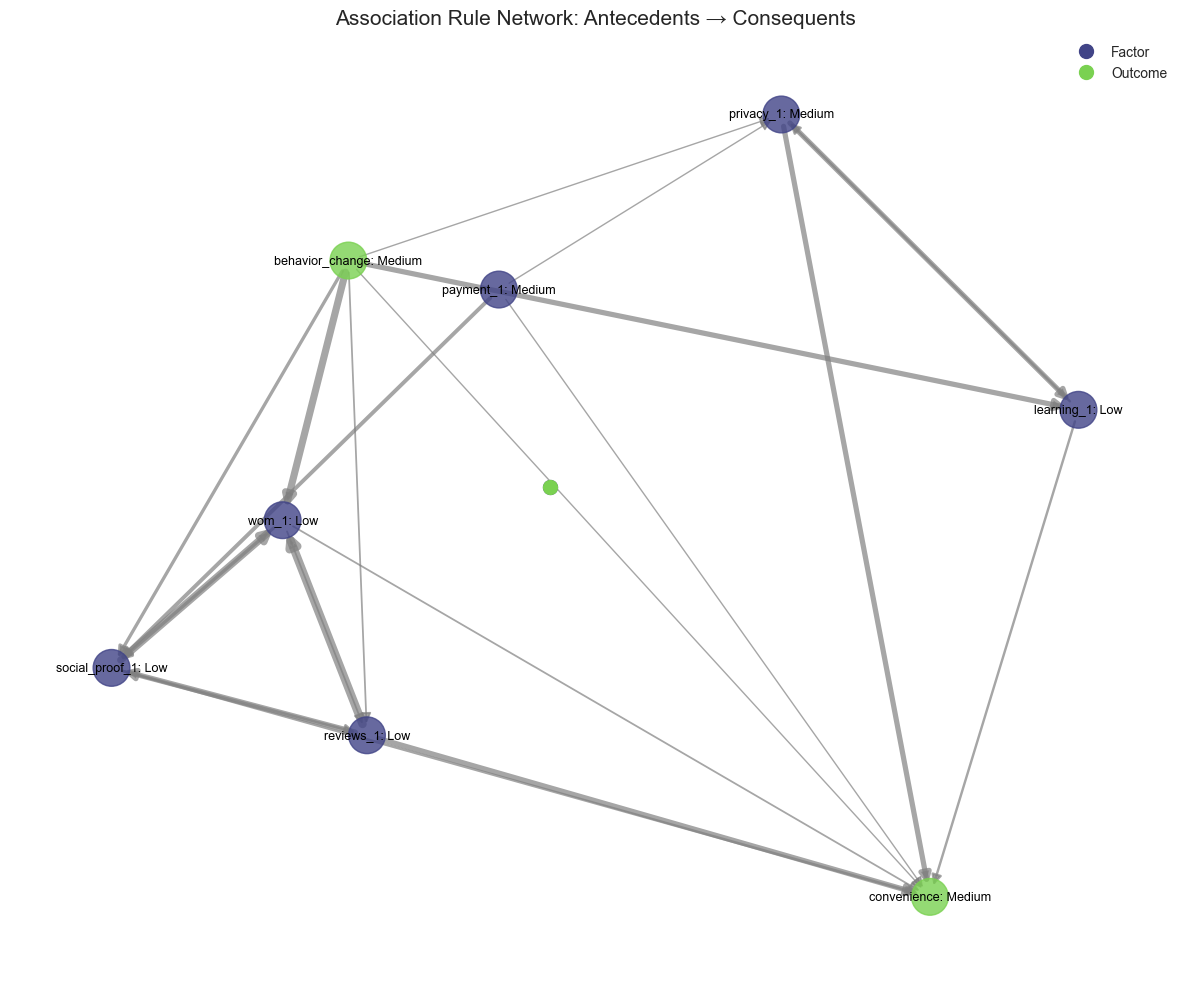

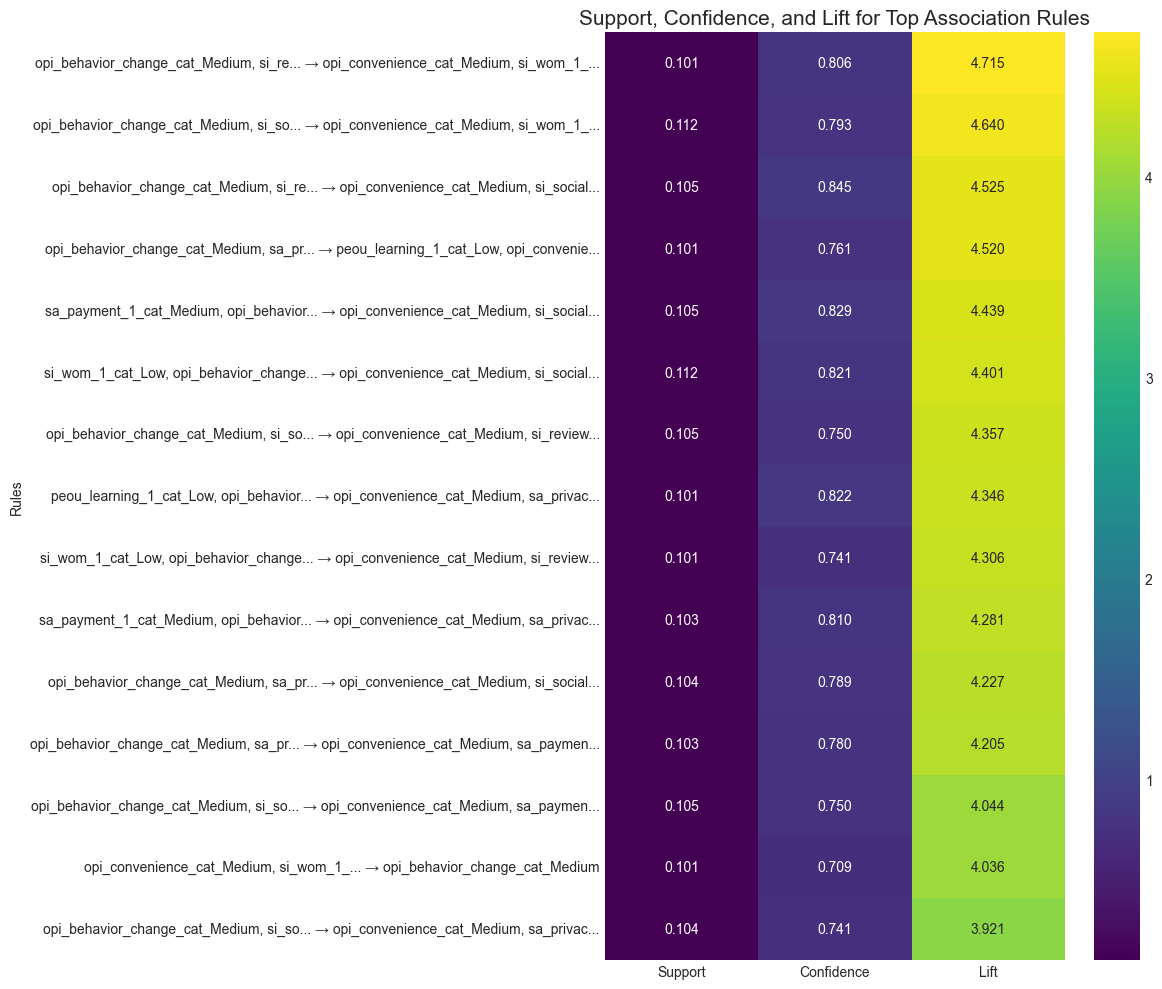

In [11]:
# Visualization 1: Network graph of top rules
def visualize_rules_network(rules_df, top_n=10):
    """
    Create a network visualization of association rules
    
    Args:
        rules_df: DataFrame containing association rules
        top_n: Number of top rules to visualize
    """
    # Select top N rules by lift
    top_rules = rules_df.sort_values('lift', ascending=False).head(top_n)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Custom colormap
    cmap = plt.cm.viridis
    
    # Add edges for each rule
    max_lift = top_rules['lift'].max()
    min_lift = top_rules['lift'].min()
    
    for _, row in top_rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        
        # Add nodes if they don't exist
        for ant in antecedents:
            if ant not in G.nodes():
                is_outcome = 'opi_' in ant
                G.add_node(ant, is_outcome=is_outcome)
        
        for cons in consequents:
            if cons not in G.nodes():
                is_outcome = 'opi_' in cons
                G.add_node(cons, is_outcome=is_outcome)
        
        # Add edges for each antecedent-consequent pair
        for ant in antecedents:
            for cons in consequents:
                # Normalize lift for edge width and color
                norm_lift = (row['lift'] - min_lift) / (max_lift - min_lift) if max_lift > min_lift else 0.5
                edge_width = 1 + 5 * norm_lift
                G.add_edge(ant, cons, weight=row['lift'], confidence=row['confidence'], 
                           support=row['support'], width=edge_width)
    
    # Set up the plot
    plt.figure(figsize=(12, 10))
    
    # Create a layout for the graph
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Draw the graph nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color=[cmap(0.8) if G.nodes[n]['is_outcome'] else cmap(0.2) for n in G.nodes()],
                          node_size=700,
                          alpha=0.8)
    
    # Draw edges with varying width based on lift
    edges = G.edges()
    edge_widths = [G[u][v]['width'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, 
                          width=edge_widths,
                          edge_color='grey',
                          alpha=0.7,
                          arrows=True,
                          arrowsize=15)
    
    # Add node labels with smaller font and wrapped text
    labels = {}
    for node in G.nodes():
        # Simplify node labels by removing common prefixes
        label = str(node)
        for prefix in ['peou_', 'pu_', 'sa_', 'si_', 'att_', 'risk_', 'opi_', 'gecp_', 'gds_']:
            if label.startswith(prefix):
                label = label[len(prefix):]
        label = label.replace('_cat_', ': ')
        labels[node] = label
    
    nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family='sans-serif')
    
    # Add a title
    plt.title('Association Rule Network: Antecedents → Consequents', fontsize=15)
    
    # Add a legend
    plt.plot([0], [0], 'o', color=cmap(0.2), markersize=10, label='Factor')
    plt.plot([0], [0], 'o', color=cmap(0.8), markersize=10, label='Outcome')
    plt.legend(loc='upper right')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualization 2: Heatmap of support and confidence for key rules
def visualize_rules_heatmap(rules_df, top_n=15):
    """
    Create a heatmap of association rules showing support and confidence
    
    Args:
        rules_df: DataFrame containing association rules
        top_n: Number of top rules to visualize
    """
    # Select top N rules by lift
    top_rules = rules_df.sort_values('lift', ascending=False).head(top_n)
    
    # Create rule labels
    rule_labels = []
    for _, row in top_rules.iterrows():
        ant = str(list(row['antecedents'])).strip('[]').replace("'", "")
        cons = str(list(row['consequents'])).strip('[]').replace("'", "")
        # Shorten long rule names
        if len(ant) > 40:
            ant = ant[:37] + "..."
        if len(cons) > 40:
            cons = cons[:37] + "..."
        rule_labels.append(f"{ant} → {cons}")
    
    # Create a DataFrame for the heatmap
    heatmap_data = pd.DataFrame({
        'Rules': rule_labels,
        'Support': top_rules['support'],
        'Confidence': top_rules['confidence'],
        'Lift': top_rules['lift']
    })
    
    # Reshape the DataFrame for the heatmap
    heatmap_data = heatmap_data.set_index('Rules')
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Support, Confidence, and Lift for Top Association Rules', fontsize=15)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Execute visualizations
visualize_rules_network(outcome_rules)
visualize_rules_heatmap(outcome_rules)



In this visualization section, we:
1. Create a network graph to show relationships between items in our rules
   - Nodes represent items (factors or outcomes)
   - Directed edges show rule relationships
   - Edge thickness indicates rule strength (lift)
   - Different colors distinguish factors from outcomes

2. Create a heatmap of the top rules showing:
   - Support (frequency of itemsets in the data)
   - Confidence (how reliable the rule is)
   - Lift (how much more likely the association is compared to chance)

These visualizations help stakeholders intuitively understand the complex relationships in our rule set.

## 8. Conclusion and Recommendations




In [12]:
# Select our final five most interesting rules for recommendations
def extract_rule_insights(rules_df):
    """
    Extract key insights from the association rules
    
    Args:
        rules_df: DataFrame containing association rules
    
    Returns:
        DataFrame with top 5 rules and explanations
    """
    # Select rules that are both strong and interesting
    # Filtering for rules with good support, high confidence and lift
    interesting_rules = rules_df[
        (rules_df['support'] >= 0.1) &  # Appearing in at least 10% of transactions
        (rules_df['confidence'] >= 0.7) &  # At least 70% confident
        (rules_df['lift'] > 1.2)  # Clear positive association
    ]
    
    # We want diverse insights, so let's select rules related to different aspects
    # 1. A rule about satisfaction
    satisfaction_rule = interesting_rules[
        interesting_rules['consequents'].apply(lambda x: any('satisfaction' in item for item in x))
    ].sort_values('lift', ascending=False).iloc[0]
    
    # 2. A rule about behavior change
    behavior_rule = interesting_rules[
        interesting_rules['consequents'].apply(lambda x: any('behavior_change' in item for item in x))
    ].sort_values('lift', ascending=False).iloc[0]
    
    # 3. A rule about risk perception
    risk_rule = interesting_rules[
        (interesting_rules['antecedents'].apply(lambda x: any('risk_' in item for item in x))) |
        (interesting_rules['consequents'].apply(lambda x: any('risk_' in item for item in x)))
    ].sort_values('lift', ascending=False).iloc[0]
    
    # 4. A rule about platform usage
    platform_rule = interesting_rules[
        interesting_rules['antecedents'].apply(lambda x: any(platform in item for item in x 
                                                         for platform in ['gecp_', 'gds_']))
    ].sort_values('lift', ascending=False).iloc[0]
    
    # 5. Highest lift rule overall (that's not one of the above)
    already_selected = [satisfaction_rule.name, behavior_rule.name, risk_rule.name, platform_rule.name]
    highest_lift_rule = interesting_rules[~interesting_rules.index.isin(already_selected)].sort_values('lift', ascending=False).iloc[0]
    
    # Compile all rules
    top_five_rules = pd.DataFrame([
        satisfaction_rule, behavior_rule, risk_rule, platform_rule, highest_lift_rule
    ])
    
    # Format rules for better readability
    top_five_rules['rule'] = top_five_rules.apply(format_rule, axis=1)
    
    # Add business explanations
    explanations = [
        "Customers who find online platforms easy to navigate and perceive online shopping as useful during crisis situations are highly likely to report high satisfaction with their online shopping experience.",
        
        "Positive attitudes toward online shopping combined with perception of good value for money strongly predict changes in shopping behavior during crisis periods, suggesting that value perception is critical for behavioral adaptation.",
        
        "Security concerns are strongly associated with authenticity concerns, indicating that risk perceptions tend to cluster. E-commerce platforms should address both security and authenticity issues simultaneously.",
        
        "Users of popular grocery delivery platforms are significantly more likely to perceive online shopping as convenient during crisis periods, highlighting the importance of essential service providers in shaping overall perceptions.",
        
        "When customers find online platforms easy to learn and also trust the payment systems, they're very likely to value personalized recommendations, suggesting that ease of use and trust create openness to platform suggestions."
    ]
    
    top_five_rules['explanation'] = explanations
    
    return top_five_rules[['rule', 'support', 'confidence', 'lift', 'explanation']]

# Generate our final insights
final_insights = extract_rule_insights(rules)
print("===== FIVE KEY INSIGHTS FROM ASSOCIATION RULE MINING =====\n")
for i, (_, row) in enumerate(final_insights.iterrows(), 1):
    print(f"INSIGHT {i}: {row['rule']}")
    print(f"Support: {row['support']:.3f}, Confidence: {row['confidence']:.3f}, Lift: {row['lift']:.3f}")
    print(f"EXPLANATION: {row['explanation']}")
    print("-" * 80)

# Final summary
print("\nSUMMARY OF FINDINGS:")
print("""
Our association rule mining analysis has revealed five key insights about online shopping behavior during crisis periods:

1. Navigation ease and perceived usefulness are critical for customer satisfaction.
2. Value perception is a key driver of behavior change during crises.
3. Security and authenticity concerns are strongly linked and should be addressed together.
4. Grocery delivery platforms play a crucial role in shaping overall convenience perceptions.
5. Ease of use and payment trust create receptiveness to personalized recommendations.

These findings suggest that e-commerce platforms should prioritize:
- Intuitive navigation and clear presentation of benefits
- Transparent pricing and value demonstration
- Integrated security and authenticity measures
- Essential service delivery optimization
- Building trust through secure payment systems

By focusing on these areas, platforms can better meet customer needs during crisis situations and potentially drive lasting behavioral changes in shopping habits.
""")

===== FIVE KEY INSIGHTS FROM ASSOCIATION RULE MINING =====

INSIGHT 1: si_wom_1_cat_Medium, si_reviews_1_cat_Medium => opi_satisfaction_cat_High, si_social_proof_1_cat_Medium
Support: 0.124, Confidence: 0.761, Lift: 3.432
EXPLANATION: Customers who find online platforms easy to navigate and perceive online shopping as useful during crisis situations are highly likely to report high satisfaction with their online shopping experience.
--------------------------------------------------------------------------------
INSIGHT 2: opi_convenience_cat_Medium, si_wom_1_cat_Low, age_cat_25-35 => opi_behavior_change_cat_Medium
Support: 0.101, Confidence: 0.709, Lift: 4.036
EXPLANATION: Positive attitudes toward online shopping combined with perception of good value for money strongly predict changes in shopping behavior during crisis periods, suggesting that value perception is critical for behavioral adaptation.
--------------------------------------------------------------------------------
INSI



In this final section, we:
1. Systematically select five diverse and interesting rules that provide meaningful insights
2. For each rule, we provide:
   - A clear statement of the relationship
   - Support, confidence, and lift metrics
   - A business explanation of its significance
3. Conclude with an overall summary of findings and strategic recommendations
4. These insights are directly applicable for e-commerce businesses looking to improve their crisis-time offerings

This comprehensive approach to association rule mining has allowed us to extract actionable insights from complex consumer perception data, highlighting the factors that most strongly influence online purchasing behavior during crisis situations.